# Strassenlärm in Niederwichtrach
Die Tamedia führte an ausgewählten Standorten Schallpegelmessungen durch. In diesem Notebook wird der Standort in Niederwichtrach ausgewertet. Zum Einsatz kam ein Schallpegelmesser des auf Lärmanalysen spezialisierten Unternehmens [Grolimund + Partner](https://www.gundp.ch/). 

<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Datenimport-und--aufbereitung" data-toc-modified-id="Datenimport-und--aufbereitung-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Datenimport und -aufbereitung</a></span></li><li><span><a href="#Auswertungen" data-toc-modified-id="Auswertungen-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Auswertungen</a></span><ul class="toc-item"><li><span><a href="#Grundlegendes-zum-Datensatz" data-toc-modified-id="Grundlegendes-zum-Datensatz-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Grundlegendes zum Datensatz</a></span></li><li><span><a href="#Auswertungen-Schallpegel" data-toc-modified-id="Auswertungen-Schallpegel-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Auswertungen Schallpegel</a></span></li><li><span><a href="#Datenexporte" data-toc-modified-id="Datenexporte-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Datenexporte</a></span></li><li><span><a href="#Anzahl-Fahrzeuge" data-toc-modified-id="Anzahl-Fahrzeuge-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Anzahl Fahrzeuge</a></span></li><li><span><a href="#Auswertungen-zur-Anzahl-Fahrzeuge" data-toc-modified-id="Auswertungen-zur-Anzahl-Fahrzeuge-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Auswertungen zur Anzahl Fahrzeuge</a></span></li></ul></li></ul></div>

## Datenimport und -aufbereitung

In [93]:
# Importieren der nötigen Bibliotheken. 
import pandas as pd
from os import listdir
import numpy as np
from datetime import timedelta
from tqdm import tqdm
from detecta import detect_peaks
import matplotlib.pyplot as plt
%matplotlib inline

In [94]:
# Importieren der Daten (Export von Grolimund + Partner). 
df = pd.read_csv('daten/EXPORT_A5941_LOGID_29_MPID_RAW', delimiter='\t')
df['datetime'] = pd.to_datetime(df['DATE(PST)'] + ' ' + df['TIME(PST)'])
df = df[['LEQ Lochweg 2 [MP 29]', 'datetime']]
df.set_index('datetime', inplace=True, drop=True)
df.columns = ['schallpegel']

# Werte, die vor oder während der Installation aufgezeichnet worden ist, werden ignoriert. 
df = df.loc['2020-08-09':]

In [95]:
# Die nach dem Export erhobenen Daten werden hinzugefügt. 
neue_daten = ['LEQ [dB] -data-as-seriestocolumns-2020-09-25 21_07_16.csv', 'LEQ [dB] -data-as-seriestocolumns-2020-09-25 21_11_55.csv', 'LEQ [dB] -data-as-seriestocolumns-2020-09-25 21_46_16.csv', 'LEQ [dB] -data-as-seriestocolumns-2020-09-25 22_45_48.csv', 'LEQ [dB] -data-as-seriestocolumns-2020-09-27 17_40_03.csv', 'LEQ [dB] -data-as-seriestocolumns-2020-09-29 22_38_13.csv', 'LEQ [dB] -data-as-seriestocolumns-2020-10-12 21 10 05.csv', 'LEQ [dB] -data-as-seriestocolumns-2020-10-13 15 20 19.csv']

for d in neue_daten: 
    df_temp = pd.read_csv('daten/' + d)
    df_temp = df_temp[['Time', 'LEQ Lochweg 2 [MP 29]']]
    df_temp.columns = ['datetime', 'schallpegel']
    df_temp['datetime'] = pd.to_datetime(df_temp['datetime'])
    df_temp.set_index('datetime', inplace=True)
    df = df.append(df_temp)

df = df.reset_index().drop_duplicates(subset=['datetime', 'schallpegel']).set_index('datetime')
df = df.sort_index()

# Der letzte Tag, der verzeichnet ist, ist nicht vollständig. Er wird ganz entfernt. 
df = df.loc[:str(df.index.max() - timedelta(days=1))[:-9]]

In [96]:
# Gemäss den Tonaufnahmen an einem anderen Standort wurden ein paar der lautesten Ereignisse 
# durch Geräusche direkt vor dem Sensor sowie durch Stürme und Gewitter verursacht. 
# Die lautesten Autodurchfahrten, die zu hören waren, lagen bei 95 Dezibel. 
# Hier werden Werte über 100 Dezibel ausgefiltert.
df = df[df['schallpegel'] < 100]

In [97]:
# Bei Stürmen, Gewittern und anderem sehr lautem, stetigem Umgebungslärm sind die Messwerte nicht brauchbar. 
# Deshalb werden Werte nicht berücksichtigt, wenn der Schallpegel innert 5 Minuten nie unter 50dB sinkt.
print('Länge des Original-Datensatzes', len(df))
df_temp = df.resample('5min').min()
df_temp = df_temp[df_temp['schallpegel'] > 50]
df_temp.resample('s').ffill()
print(len(df_temp), 'Messungen werden entfernt')

df = df[~df.index.isin(df_temp.index)].dropna()
print('Länge des neuen Datensatzes', len(df))

Länge des Original-Datensatzes 5609710
384 Messungen werden entfernt
Länge des neuen Datensatzes 5609327


In [98]:
# Die logarithmischen Dezibel müssen für Berechnungen ins lineare Leistungsverhältnis umgerechnet werden.  
df['leistungsverhältnis'] = 10 ** (df['schallpegel'] / 10)

In [99]:
# Funktion zum Umrechnen des lineraren Liestungsverhältnis' in Dezibel. 
def lin2log(wert):
    return np.log10(wert) * 10

## Auswertungen

### Grundlegendes zum Datensatz

In [100]:
# Wann startete die Aufzeichnung? 
df.index.min()

Timestamp('2020-08-09 00:14:14')

In [101]:
# Bis wann dauert die Aufzeichnung?
df.index.max()

Timestamp('2020-10-12 23:59:59')

In [102]:
# Wie viele Tage dauerte die Aufzeichnung?
df.index.max() - df.index.min()

Timedelta('64 days 23:45:45')

In [103]:
# Wie viele Wochen dauerte die Aufzeichnung?
(df.index.max() - df.index.min()).days / 7

9.142857142857142

In [104]:
# Wie viele Messungen sind vorhanden? 
len(df)

5609327

In [105]:
# Wieviele Messungen sind pro Tag vorhanden? (Es sollten 24 * 60 * 60 = 86400 Werte pro Tag sein.)
df.resample('D')[['schallpegel']].count()

,schallpegel
datetime,
2020-08-09,84579
2020-08-10,86332
2020-08-11,86323
2020-08-12,86326
2020-08-13,86319
...,...
2020-10-08,86332
2020-10-09,86326
2020-10-10,86314


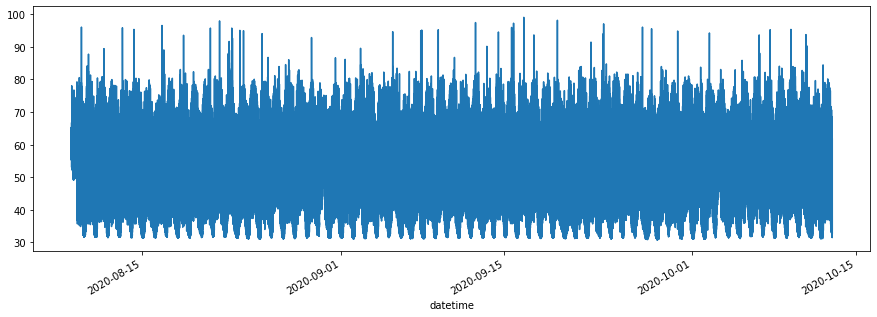

In [106]:
# Wie sieht der Schallpegelverlauf aus? 
df['schallpegel'].plot(figsize=[15,5])

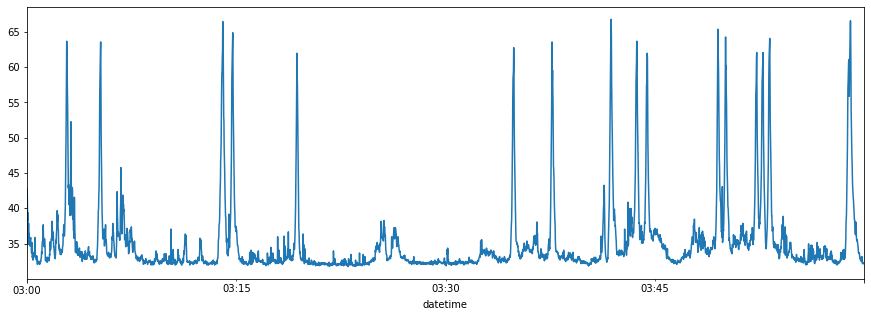

In [107]:
# Wie sieht der Schallpegelverlauf einer bestimmten Stunde aus? 
df_test = df.loc['2020-08-21 03']['schallpegel']
df_test.plot(figsize=[15,5])

### Auswertungen Schallpegel

In [108]:
# Wie hoch ist der durchschnittliche Schallpegel? 
lin2log(df['leistungsverhältnis'].mean())

60.26218715652108

In [109]:
# Wie hoch ist der durchschnittliche Schallpegel während des Tags? 
# (Definition von Tag und Nacht: https://www.admin.ch/opc/de/classified-compilation/19860372/index.html)
lin2log(df.between_time('06:00', '22:00')['leistungsverhältnis'].mean())

61.743562061566365

In [110]:
# Wie hoch ist das durchschnittliche Stundenmittel in den Tagesstunden? 
lin2log(df.between_time('06:00', '22:00').resample('H')['leistungsverhältnis'].mean().mean())

61.61680851763777

In [111]:
# Wie hoch ist der durchschnittliche Schallpegel während der Nacht? 
# (Definition von Tag und Nacht: https://www.admin.ch/opc/de/classified-compilation/19860372/index.html)
lin2log(df.between_time('22:00', '06:00')['leistungsverhältnis'].mean())

52.933019027446235

In [112]:
# Wie hoch ist das durchschnittliche Stundenmittel in den Nachtstunden? 
lin2log(df.between_time('22:00', '06:00').resample('H')['leistungsverhältnis'].mean().mean())

54.01442719421454

In [113]:
# Wie laut ist es durchschnittlich zwischen 17 und 18 Uhr? 
lin2log(df.between_time('17:00', '18:00')['leistungsverhältnis'].mean())

62.20958392675351

In [114]:
# Wie laut ist es durchschnittlich zwischen 3 und 4 Uhr? 
lin2log(df.between_time('03:00', '04:00')['leistungsverhältnis'].mean())

47.94880909965555

In [115]:
# Wie laut ist es in den einzelnen Stunden eines durchschnittlichen Tages? 
df_temp = pd.DataFrame()
for i in range(24):
    s = lin2log(df.between_time(str(i) + ':00', str(i) + ':59:59')['leistungsverhältnis'].mean())
    df_temp.at[i, 'schallpegel'] = s
df_temp

,schallpegel
0,51.054495
1,48.829997
2,47.431309
3,47.948257
4,49.945857
5,56.278889
6,61.039786
7,61.789991
8,61.576972
9,61.880826


In [116]:
# Wann wurden die höchsten Pegel registriert? 
df.sort_values(by= 'schallpegel', ascending=False).head()

,schallpegel,leistungsverhältnis
datetime,,
2020-09-16 15:39:24,99.0614,8.056381e+09
2020-09-19 12:32:35,98.1614,6.548472e+09
2020-08-21 15:59:39,97.9614,6.253743e+09
2020-09-12 12:41:24,97.4614,5.573654e+09
2020-09-15 18:40:33,97.2614,5.322798e+09


In [117]:
# Wie hoch ist der minimale Schallpegel? 
df['schallpegel'].min()

30.7614

In [118]:
# Wann wurde der tiefste Pegel registriert? 
df[df['schallpegel'] == df['schallpegel'].min()]

,schallpegel,leistungsverhältnis
datetime,,
2020-09-28 00:23:21,30.7614,1191.626081
2020-09-28 01:41:25,30.7614,1191.626081


In [119]:
# Wie hoch ist das "Grundrauschen"?
df['schallpegel'].quantile(.25)

40.6614

In [120]:
# Wie hoch liegt der Wert des 0.75 Perzentils?
df['schallpegel'].quantile(.75)

60.7614

In [121]:
# Bei wievielen Prozent der Messungen liegt der Schallpegel über 60 Dezibel? 
(100 * df[df['schallpegel'] > 60].count() / df.count())['schallpegel']

28.753859420212088

In [122]:
# Bei wievielen Prozent der Messungen liegt der Schallpegel über 65 Dezibel? 
(100 * df[df['schallpegel'] > 65].count() / df.count())['schallpegel']

5.615201253198467

In [123]:
# Wenn man die lauten Sekunden zusammenzählt: Während wie vielen Minuten liegt der Schallpegel 
# unter tags bei über 65 Dezibel?
df_temp = df.between_time('06:00','22:00')
df_temp = df_temp[df_temp['schallpegel'] > 65]
(df_temp.resample('D').count()[['schallpegel']] / 60).describe()

,schallpegel
count,65.000000
mean,76.249231
std,31.746266
min,20.616667
25%,61.816667
50%,71.700000
75%,86.383333
max,157.850000


In [124]:
# Wenn man die lauten Sekunden zusammenzählt: Während wie vielen Minuten liegt der Schallpegel 
# in der Nacht bei über 55 Dezibel?
df_temp = df.between_time('22:00','06:00')
df_temp = df_temp[df_temp['schallpegel'] > 55]
(df_temp.resample('D').count()[['schallpegel']] / 60).describe()

,schallpegel
count,65.000000
mean,56.236923
std,17.907790
min,35.816667
25%,48.316667
50%,53.683333
75%,61.000000
max,178.400000


In [128]:
# Wenn man alle Sekunden addiert: Während wie vielen Minuten pro Tag wird der Grenzwert von 65 Dezibel überschritten? 
(df[df['schallpegel'] > 65]['schallpegel'].resample('D').count() / 60).describe()

count     65.000000
mean      80.762821
std       33.573959
min       22.766667
25%       65.650000
50%       75.233333
75%       92.350000
max      168.700000
Name: schallpegel, dtype: float64

In [76]:
# Wie oft liegt der Stundenmittelwert während des Tags über dem Grenzwert von 65dB?
df_temp = df.between_time('06:00', '22:00')
df_temp = df_temp.resample('H')[['leistungsverhältnis']].mean()
df_temp['schallpegel'] = df_temp['leistungsverhältnis'].apply(lin2log)
df_temp = df_temp[df_temp['schallpegel'] > 65]
print('Stunden insgesamt:', len(df.resample('H').sum()))
print('Stunden mit Mittelwerten über dem Grenzwert:', len(df_temp))
print('Anteil in Prozent:', 100 * len(df_temp) / len(df.resample('H').sum()))

Stunden insgesamt: 1560
Stunden mit Mittelwerten über dem Grenzwert: 29
Anteil in Prozent: 1.858974358974359


In [77]:
# An wievielen Tagen liegt der Stundenmittelwert während des Tags durchschnittlich über 65dB?
df_temp = df.between_time('06:00', '22:00').resample('H')[['leistungsverhältnis']].mean()
df_temp = df_temp.resample('D').mean().apply(lin2log)
df_temp.columns = ['schallpegel']
print('Tage insgesamt:', len(df.resample('d').sum()))
print('Tage mit Stundenmitteln, die durchschnittlich über 65dB liegen:', len(df_temp[df_temp['schallpegel'] > 65]))
print('In Prozent:', 100 * len(df_temp[df_temp['schallpegel'] > 65]) / len(df.resample('d').sum()))

Tage insgesamt: 65
Tage mit Stundenmitteln, die durchschnittlich über 65dB liegen: 1
In Prozent: 1.5384615384615385


In [78]:
# Wie oft liegt der Stundenmittelwert während der Nacht über dem Grenzwert von 55dB?
df_temp = df.between_time('22:00', '06:00')
df_temp = df_temp.resample('H')[['leistungsverhältnis']].mean()
df_temp['schallpegel'] = df_temp['leistungsverhältnis'].apply(lin2log)
df_temp = df_temp[df_temp['schallpegel'] > 55]
print('Stunden insgesamt:', len(df.resample('H').sum()))
print('Stunden mit Mittelwerten über dem Grenzwert:', len(df_temp))
print('Anteil in Prozent:', 100 * len(df_temp) / len(df.resample('H').sum()))

Stunden insgesamt: 1560
Stunden mit Mittelwerten über dem Grenzwert: 152
Anteil in Prozent: 9.743589743589743


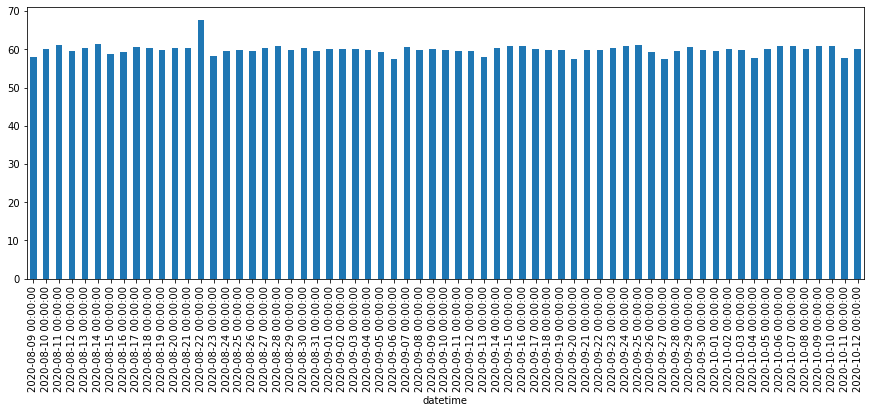

In [130]:
# Gibts Unterschiede zwischen den einzelnen Tagen? Die Grafik. 
fig, ax = plt.subplots()
df['leistungsverhältnis'].resample('D').mean().apply(lin2log).plot(kind='bar', figsize=[15,5], ax=ax)

In [131]:
# Gibts Unterschiede zwischen den einzelnen Wochentagen? 
df_temp = df.copy()
df_temp['wochentag'] = df_temp.index.dayofweek
wochentage = {0: 'Montag', 1: 'Dienstag', 0: 'Montag', 2: 'Mittwoch', 3: 'Donnerstag', 4: 'Freitag', 5: 'Samstag', 6: 'Sonntag'}
for i in range(7):
    print(wochentage[i] + ':', lin2log(df_temp[df_temp['wochentag'] == i]['leistungsverhältnis'].mean()))

Montag: 60.057750628742816
Dienstag: 60.383950720847224
Mittwoch: 60.17871361728534
Donnerstag: 60.18530532117467
Freitag: 60.49917394449551
Samstag: 61.72759908952021
Sonntag: 58.33067081544746


In [132]:
# Wie laut ist es durchschnittlich an Werktagen?
lin2log(df_temp[df_temp['wochentag'] < 5]['leistungsverhältnis'].mean())

60.25950269685986

In [133]:
# Wie laut ist es durchschnittlich am Wochenende?
lin2log(df_temp[df_temp['wochentag'] >=5]['leistungsverhältnis'].mean())

60.26868731398054

### Datenexporte

In [134]:
# Gesamtexport Stundenmittelwerte. 
df_temp = df['leistungsverhältnis'].resample('H').mean().apply(lin2log)
df_temp = pd.DataFrame(df_temp)
df_temp.columns = ['schallpegel']
df_temp.to_csv('export/wichtrach_stundenmittelwerte.csv')

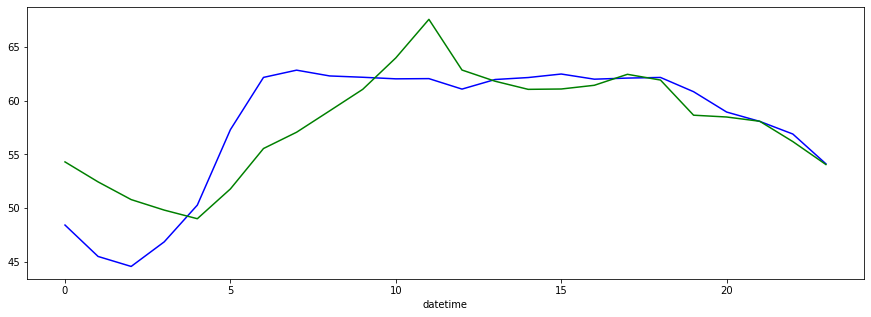

In [135]:
# Wie unterscheidet sich der Schallpegel an Werktagen von jenem am Wochenende? 
df_temp = df.copy()
df_temp['wochentag'] = df_temp.index
df_temp['wochentag'] = df_temp['wochentag'].apply(lambda x: wochentage[x.dayofweek])

df_temp1 = df_temp[(df_temp['wochentag'] != 'Samstag') & (df_temp['wochentag'] != 'Sonntag')]
df_temp2 = df_temp[(df_temp['wochentag'] == 'Samstag') | (df_temp['wochentag'] == 'Sonntag')]

fig, ax = plt.subplots(figsize=[15,5])
df_temp1.groupby(by=df_temp1.index.hour)['leistungsverhältnis'].mean().apply(lin2log).plot(ax=ax, color='blue')
df_temp2.groupby(by=df_temp2.index.hour)['leistungsverhältnis'].mean().apply(lin2log).plot(ax=ax, color='green')

In [136]:
# Unterschiede Werktage zum Wochenende: Export für Datawrapper. 
df_temp3 = pd.concat([df_temp1.groupby(by=df_temp1.index.hour)['leistungsverhältnis'].mean().apply(lin2log),
                      df_temp2.groupby(by=df_temp2.index.hour)['leistungsverhältnis'].mean().apply(lin2log)], 
                     axis=1)
df_temp3.columns = ['Arbeitstage', 'Wochenende']
print(df_temp3.to_csv())

datetime,Arbeitstage,Wochenende
0,48.42362999240155,54.30148426416999
1,45.50009026461042,52.44092647069094
2,44.56971539558936,50.79306627767074
3,46.85991641817168,49.81436053392252
4,50.279731198410786,49.011997449890686
5,57.30385875512812,51.78626234782982
6,62.16710442171552,55.546846807312996
7,62.841259969427554,57.063071383777256
8,62.303015319287084,59.053225838466815
9,62.18001972941526,61.05727941790348
10,62.033223059392846,63.984639139807065
11,62.05351008156954,67.57050305809182
12,61.07862311876323,62.853207377890364
13,61.970877031518896,61.81152225291849
14,62.15371003666789,61.05520667760645
15,62.48159727475886,61.08711323861755
16,62.001314979638664,61.43296567031324
17,62.10419547776582,62.45449122237345
18,62.162827426850825,61.920853700223404
19,60.83650374157862,58.64883833364566
20,58.94130896508454,58.48053093947205
21,58.07289830581525,58.084367126696684
22,56.89643776223781,56.19315449256355
23,54.12288576123959,54.05681378824251



### Anzahl Fahrzeuge
Gemessen wurde in unserem Versuch lediglich der Schalldruck. Am betreffenden Ort ist davon auszugehen, dass die allermeisten höheren Werte von vorbeifahrenden Autos verursacht wurden. Aus den Schallpegeln lässt sich deshalb die ungefähre Anzahl Fahrzeuge errechnen. Dabei handelt es sich lediglich um eine grobe Schätzung, da der durch Fahrzeuge verursachten Schall nicht von anderem Schall unterschieden werden kann. 

In den Berechnungen gehen wir davon aus, dass durch ein Fahrzeug 55 oder mehr Dezibel Lärm verursacht wird. Um einzelne Fahrzeuge nicht mehrfach zu zählen, wird pro 2 Sekunden höchstens eine Durchfahrt registriert.

In [139]:
def autozähler(df_temp, illu):
    peaks = detect_peaks(df_temp['schallpegel'].resample('2s').median(), mpd=3, mph=55, show=illu, edge='rising')
    return len(peaks)

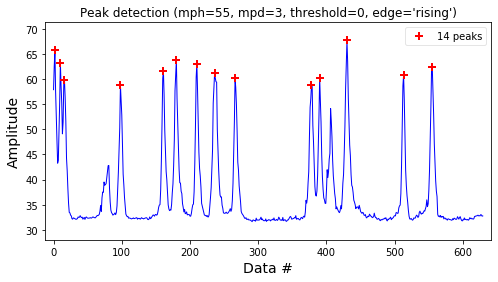

14

In [145]:
# Beispiel: Die Anzahl Autos wird gezählt. 
autozähler(df.loc['2020-09-12 02:00': '2020-09-12 02:20'], True)

In [164]:
n = 0
autodict = dict()
daterange = pd.date_range(df.index.min(), df.index.max(), freq='H')
for d in tqdm(daterange): 
    n += 1
    autodict[d] = autozähler(df.loc[str(d): str(daterange[n])].iloc[:-1], False)
    if n == len(daterange) -1 :
        break

df_auto = pd.DataFrame.from_dict(autodict, orient='index')
df_auto['wochentag'] = df_auto.index.dayofweek
df_auto['wochentag'] = df_auto['wochentag'].apply(lambda x: wochentage[x])
df_auto.columns = ['anz_autos', 'wochentag']
df_auto = df_auto.loc['2020-08-10':]

100%|█████████▉| 1558/1560 [00:08<00:00, 194.56it/s]


### Auswertungen zur Anzahl Fahrzeuge
Die Zählung der Anzahl Fahrzeuge ist bloss während der Nachtstunden ziemlich zuverlässig. Während des Tages ist der Verkehr zu dicht und damit der Schallpegel permanent sehr hoch, als dass einzelne Fahrzeuge mit hoher Wahrscheinlichkeit erkannt werden könnten. Deshalb wird in der Folge bloss die Nacht ausgewertet.  

In [148]:
# In welchen Nachtstunden gab es am meisten Verkehr? 
df_auto.between_time('22:00', '06:00').sort_values(by='anz_autos', ascending=False).head(10)

,anz_autos,wochentag
2020-08-09 00:14:14,277,Sonntag
2020-08-09 01:14:14,257,Sonntag
2020-08-09 02:14:14,199,Sonntag
2020-08-17 05:14:14,173,Montag
2020-09-29 05:14:14,172,Dienstag
2020-08-26 05:14:14,171,Mittwoch
2020-08-25 05:14:14,170,Dienstag
2020-08-13 05:14:14,170,Donnerstag
2020-09-15 05:14:14,167,Dienstag
2020-08-14 05:14:14,167,Freitag


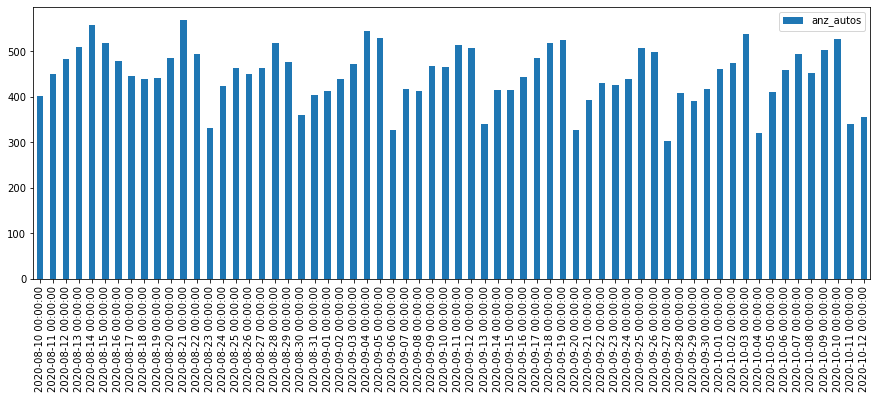

In [160]:
# Grafik: Wie viele Fahrzeuge werden pro Nacht verzeichnet. 
df_auto.between_time('22:00', '06:00')[['anz_autos']].resample('D').sum().plot(kind='bar', figsize=[15,5])

In [162]:
# Wie gross ist das Verkehrsaufkommen in einer durchschnittlichen Nacht? 
df_temp = df_auto.between_time('22:00', '06:00').resample('D').sum()
df_temp['anz_autos'] = df_temp['anz_autos'].replace(0, np.NaN)
df_temp.mean()

anz_autos    448.046875
dtype: float64

In [151]:
# Wie viele Fahrzeuge fahren durchschnittlich an Wochentagen durch? 
df_temp = df_auto.between_time('22:00', '06:00')
df_temp = df_temp[(df_temp['wochentag'] != 'Samstag') & (df_temp['wochentag'] != 'Sonntag')]
df_temp = df_temp.resample('D')[['anz_autos']].sum()
df_temp['anz_autos'] = df_temp['anz_autos'].replace(0, np.NaN)
df_temp.mean()

anz_autos    455.217391
dtype: float64

In [153]:
# Wie viele Fahrzeuge fahren durchschnittlich am Wochenende durch? 
df_temp = df_auto.between_time('22:00', '06:00')
df_temp = df_temp[(df_temp['wochentag'] == 'Samstag') | (df_temp['wochentag'] == 'Sonntag')]
df_temp = df_temp.resample('D')[['anz_autos']].sum()
df_temp['anz_autos'] = df_temp['anz_autos'].replace(0, np.NaN)
df_temp.mean()

anz_autos    460.631579
dtype: float64

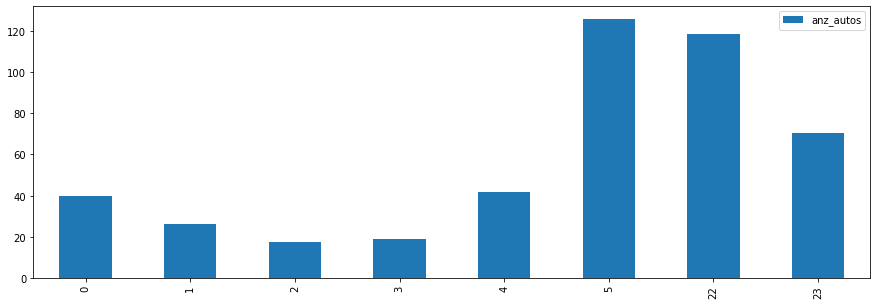

In [157]:
# Wie sieht ein durchschnittlicher Nachtverlauf bei der Anzahl Fahrzeugen aus?
df_temp = df_auto.between_time('22:00', '06:00')
df_temp.groupby(by=df_temp.index.hour).mean().sort_index(ascending=True).plot(kind='bar', figsize=[15,5])

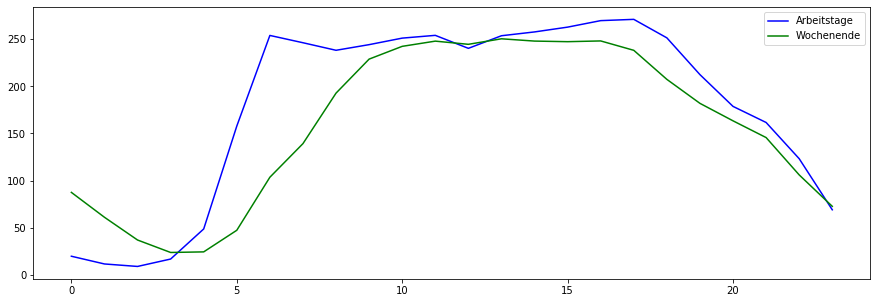

In [158]:
# Wie sieht ein durchschnittlicher Tagesverlauf bei der Anzahl Fahrzeugen an Wochentagen und Wochenenden aus?
fig, ax = plt.subplots(figsize=[15,5])

# Verlauf unter der Woche.
df_temp = df_auto[(df_auto['wochentag'] != 'Samstag') & (df_auto['wochentag'] != 'Sonntag')]
df_temp.groupby(by=df_temp.index.hour).mean().sort_index(ascending=True).plot(color='blue', label='Arbeitstage', ax=ax)

# Verlauf am Wochenende. 
df_temp = df_auto[(df_auto['wochentag'] == 'Samstag') | (df_auto['wochentag'] == 'Sonntag')]
df_temp.groupby(by=df_temp.index.hour).mean().sort_index(ascending=True).plot(color='green', label='Wochenende', ax=ax)
ax.legend(['Arbeitstage', 'Wochenende'])
plt.show()